In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import keras
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers.core import Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

from keras.utils import plot_model, to_categorical

Using TensorFlow backend.


In [2]:
df = pd.read_csv("FX_MA_100days_10years.csv")
df.head()

,time,open,high,low,close,100mean,target
0,2009-04-22 06:00:00,98.730,98.750,97.558,98.016,94.85342,1
1,2009-04-23 06:00:00,98.016,98.449,97.632,97.948,94.92540,1
2,2009-04-24 06:00:00,97.948,98.150,96.636,97.168,94.97880,1
3,2009-04-26 06:00:00,97.102,97.293,96.799,96.809,95.02754,1
4,2009-04-27 06:00:00,96.808,97.119,96.436,96.772,95.06106,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3090 entries, 0 to 3089
Data columns (total 7 columns):
time       3090 non-null object
open       3090 non-null float64
high       3090 non-null float64
low        3090 non-null float64
close      3090 non-null float64
100mean    3090 non-null float64
target     3090 non-null int64
dtypes: float64(5), int64(1), object(1)
memory usage: 169.1+ KB


In [4]:
# df = df.ix[:, ['time','close','100mean','target','open','high','low']]
# df.head()

In [5]:
# 7 : 3
df.iloc[2550]

time       2017-10-24 06:00:00
open                   113.435
high                   114.022
low                    113.252
close                  113.912
100mean                111.356
target                       1
Name: 2550, dtype: object

In [6]:
split_data = '2017-06-15 06:00:00'
train, test = df[df['time'] < split_data], df[df['time'] >= split_data]

In [7]:
train = train.set_index('time')
test = test.set_index('time')

In [8]:
X_train = train.iloc[:,:-1]
Y_train = train['target']

X_test = test.iloc[:,:-1]
Y_test = test['target']

In [9]:
X_train = X_train.as_matrix()
print(X_train)
print("Data len: ",len(X_train))

X_test = X_test.as_matrix()
print(X_train)
print("Data len: ",len(X_test))

# 正規化
ms = MinMaxScaler()
X_train = ms.fit_transform(X_train)

ms = MinMaxScaler()
X_test = ms.fit_transform(X_test)

[[ 98.73     98.75     97.558    98.016    94.85342]
 [ 98.016    98.449    97.632    97.948    94.9254 ]
 [ 97.948    98.15     96.636    97.168    94.9788 ]
 ...
 [110.342   110.44    109.632   109.941   112.03998]
 [109.938   110.27    109.815   110.066   112.00282]
 [110.054   110.342   108.815   109.564   111.96566]]
Data len:  2455
[[ 98.73     98.75     97.558    98.016    94.85342]
 [ 98.016    98.449    97.632    97.948    94.9254 ]
 [ 97.948    98.15     96.636    97.168    94.9788 ]
 ...
 [110.342   110.44    109.632   109.941   112.03998]
 [109.938   110.27    109.815   110.066   112.00282]
 [110.054   110.342   108.815   109.564   111.96566]]
Data len:  635


/home/tim0114gap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/home/tim0114gap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


In [10]:
Y_train = np.array(Y_train)
print("Y_train Target len: ",len(Y_train))

Y_test = np.array(Y_test)
print("Y_train Target len: ",len(Y_test))

Y_train Target len:  2455
Y_train Target len:  635


In [11]:
maxlen = 100
dataTrain = []
targetTrain = []
for i in range(0, len(X_train) - maxlen):
    dataTrain.append(X_train[i: i + maxlen])
    targetTrain.append(Y_train[i + maxlen])

dataTest = []
targetTest = []
for i in range(0, len(X_test) - maxlen):
    dataTest.append(X_test[i: i + maxlen])
    targetTest.append(Y_test[i + maxlen])

In [12]:
X_train = np.array(dataTrain)
Y_train = np.array(targetTrain)

X_test = np.array(dataTest)
Y_test = np.array(targetTest)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(2355, 100, 5)
(2355,)
(535, 100, 5)
(535,)


In [13]:
# Y_train = Y_train.reshape(len(Y_train), 1)
# Y_test = Y_test.reshape(len(Y_test), 1)

Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

In [14]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(2355, 100, 5)
(2355, 2)
(535, 100, 5)
(535, 2)


In [15]:
'''
モデル設定
'''
length_of_sequence = X_train.shape[1]  # 入力層 = 5
out_neurons = 2                     # 出力層 = 2
n_hidden = 100                         # 隠れ層 = 100
column = 5

model = Sequential()
model.add(LSTM(n_hidden, batch_input_shape=(None, length_of_sequence, column), return_sequences=False))
model.add(Dropout(0.25))
model.add(Dense(50))
model.add(Activation("sigmoid"))
model.add(Dropout(0.25))
model.add(Dense(25))
model.add(Activation("sigmoid"))
model.add(Dropout(0.25))
model.add(Dense(out_neurons))
model.add(Activation("softmax"))





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [16]:
optimizer = Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999)
model.compile(loss="categorical_crossentropy", 
              optimizer=optimizer, metrics=['acc'])

In [17]:
#plot_model(model, to_file='model.png')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               42400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
activation_1 (Activation)    (None, 50)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 25)                1275      
_________________________________________________________________
activation_2 (Activation)    (None, 25)                0         
__________

In [18]:
# コールバック指定（https://qiita.com/yukiB/items/f45f0f71bc9739830002）
early_stopping = EarlyStopping(monitor='val_loss', 
                               mode='auto', patience=20)
history = model.fit(X_train, Y_train,
                  batch_size = 16, # 論文で使われるのが1, 32, 128, 256, 512
                  epochs=100,
                  validation_split=0.2,
                  callbacks=[early_stopping])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 1884 samples, validate on 471 samples
Epoch 1/100
1884/1884 [==============================] - 17s 9ms/step - loss: 0.7122 - acc: 0.5685 - val_loss: 0.9699 - val_acc: 0.3036
Epoch 2/100
1884/1884 [==============================] - 16s 8ms/step - loss: 0.6348 - acc: 0.6385 - val_loss: 0.5891 - val_acc: 0.7771
Epoch 3/100
1884/1884 [==============================] - 16s 8ms/step - loss: 0.6078 - acc: 0.6582 - val_loss: 1.3422 - val_acc: 0.3227
Epoch 4/100
1884/1884 [==============================] - 16s 8ms/step - loss: 0.5267 - acc: 0.7473 - val_loss: 0.7149 - val_acc: 0.6030
Epoch 5/100
1884/1884 [==============================] - 16s 8ms/step - loss: 0.5709 - acc: 0.7309 - val_loss: 0.8224 - val_acc: 0.4013
Epoch 6/100
1884/1884 [==============================] - 16s 8ms/step - loss: 0.4877 - acc: 0.7797 - val_loss: 1.1332 - val_acc: 0.4183
Epoch 7/100
1884/1884 [====================

Epoch 58/100
1884/1884 [==============================] - 16s 8ms/step - loss: 0.2500 - acc: 0.8848 - val_loss: 0.3359 - val_acc: 0.8004


In [19]:
print("Test accuracy: %.4f" % (model.evaluate(X_test, Y_test)[1]))

535/535 [==============================] - 1s 1ms/step
Test accuracy: 0.7439


In [20]:
predict_classes = model.predict_classes(X_test)

In [21]:
Y_test = np.array([np.argmax(x) for x in Y_test])

In [22]:
pd.crosstab(Y_test, predict_classes, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,225,97,322
1,40,173,213
All,265,270,535


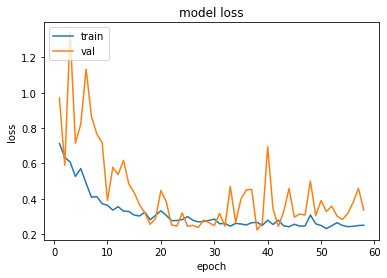

In [23]:
import matplotlib.pyplot as plt
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('FXMA100loss.png')
plt.show()

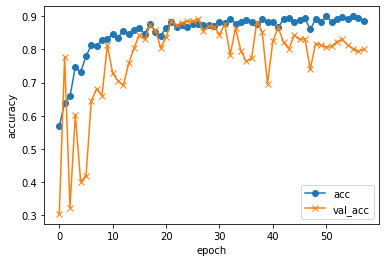

In [24]:
plt.plot(history.history["acc"], label="acc", ls="-", marker="o")
plt.plot(history.history["val_acc"], label="val_acc", ls="-", marker="x")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(loc="best")
plt.savefig('FXMA100acc.png')
plt.show()